## Import stuff

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import random
import pickle
import os

In [2]:
from mysticetus import model_driven_reco
from mysticetus.model_driven_reco import dist_model_grating_1D                   as dist_model
from mysticetus.model_driven_reco import meas_model_basic_far_field_intensity_1D as meas_model
from mysticetus.model_driven_reco import make_objective_1D                       as make_objective

In [3]:
random.seed(11)

## Sythesize 1D measurement data

In [4]:
# Define number of measurements to synthesize
nmeas       = 1

# Define definition domain
xres        = 1024
xmin        = 0.
xmax        = 10.
x           = np.linspace(xmin, xmax, xres, endpoint=False)

# Define true distribution parameters for synthetic measurement data
#true_param_list = draw_paramsets(nmeas, **domain_scales(x))
true_param_list = [{'sigma':0.1, 'pitch':2.3, 'fsize':0.8}]

# Calculate synthetic measurement data
class SyntheticMeasurement:
    pass

sm_list = []
measId  = 0
for true_params in true_param_list:
    sm_list.append(SyntheticMeasurement())
    sm_list[-1].measId      = measId
    sm_list[-1].x           = x
    sm_list[-1].true_params = true_params
    sm_list[-1].true_dist   = dist_model(true_params['sigma'], true_params['pitch'], true_params['fsize'],  x)
    sm_list[-1].meas        = meas_model(sm_list[-1].true_dist)
    measId                  += 1

## Draw start parametersets

In [5]:
# Define number of start paramsets to draw
nstart = 10

# Draw
start_params_list = model_driven_reco.draw_paramsets(nstart, ensemble=model_driven_reco.random_start_paramset, **model_driven_reco.domain_scales(x))

## Reconstruct from 1D measurement data

In [6]:
# Define number of basinhopping steps
niter=100

class RawData:
    pass

# Initialize accept_test - enforces bounds on parameters during basinhopping
parambounds= model_driven_reco.ParamBounds([np.max(x), np.max(x), np.max(x)], [0., 0., 0.])

results = []
for synthetic in sm_list:
    startId = 0
    for start_params in start_params_list:
        results.append(RawData())
        results[-1].startId      = startId
        results[-1].synthetic    = synthetic
        results[-1].start_params = start_params
        
        meas         = synthetic.meas
        x            = synthetic.x
        p0           = [start_params['sigma'], start_params['pitch'], start_params['fsize']]

        # Make objective function
        obj          = make_objective(x, meas)

        # Set up minimizer
        min_kwargs   = {'method' : 'BFGS'}

        # Run reconstruction
        xs           = [p0, ]
        fs           = [obj(p0), ]
        accs         = [True, ]
        callback     = model_driven_reco.make_callback(xs, fs, accs, 'silent')
        ret          = model_driven_reco.basinhopping(obj, p0, T=10, stepsize=5., minimizer_kwargs=min_kwargs, callback=callback, niter=niter, accept_test=parambounds)

        results[-1].xs = xs
        results[-1].fs = fs
        results[-1].accs = accs
        results[-1].bh_return = ret
        startId += 1

/home/mz6084/fowgas/packages/mysticetus/model_driven_reco.py:98: RuntimeWarning: invalid value encountered in true_divide
  diff_sq = ((meas/norm_meas) - (synth/norm_synth))**2
/home/mz6084/fowgas/packages/mysticetus/model_driven_reco.py:98: RuntimeWarning: invalid value encountered in true_divide
  diff_sq = ((meas/norm_meas) - (synth/norm_synth))**2
/home/mz6084/fowgas/packages/mysticetus/model_driven_reco.py:98: RuntimeWarning: invalid value encountered in true_divide
  diff_sq = ((meas/norm_meas) - (synth/norm_synth))**2
/home/mz6084/fowgas/packages/mysticetus/model_driven_reco.py:98: RuntimeWarning: invalid value encountered in true_divide
  diff_sq = ((meas/norm_meas) - (synth/norm_synth))**2
/home/mz6084/fowgas/packages/mysticetus/model_driven_reco.py:98: RuntimeWarning: invalid value encountered in true_divide
  diff_sq = ((meas/norm_meas) - (synth/norm_synth))**2
/home/mz6084/fowgas/packages/mysticetus/model_driven_reco.py:98: RuntimeWarning: invalid value encountered in true_

## Show 1D results

                        fun: 18.991121453356836
 lowest_optimization_result:       fun: 18.991121453356836
 hess_inv: array([[ 1.1950183 , -0.57128018, -0.07459641],
       [-0.57128018,  2.53574667,  0.28121261],
       [-0.07459641,  0.28121261,  1.        ]])
      jac: array([ 0.11327767, -0.33892012, -0.04010367])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 413
      nit: 1
     njev: 81
   status: 2
  success: False
        x: array([ 5.50515217,  4.8727711 ,  9.24210584])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 67
                       nfev: 32371
                        nit: 100
                       njev: 6361
                          x: array([ 5.50515217,  4.8727711 ,  9.24210584])
Start parameters:          {'pitch': 4.523795535098186, 'sigma': 5.59772386080496, 'fsize': 9.2421058402372935}
True parameters:           {'pitch': 2.3, 'sigma': 0

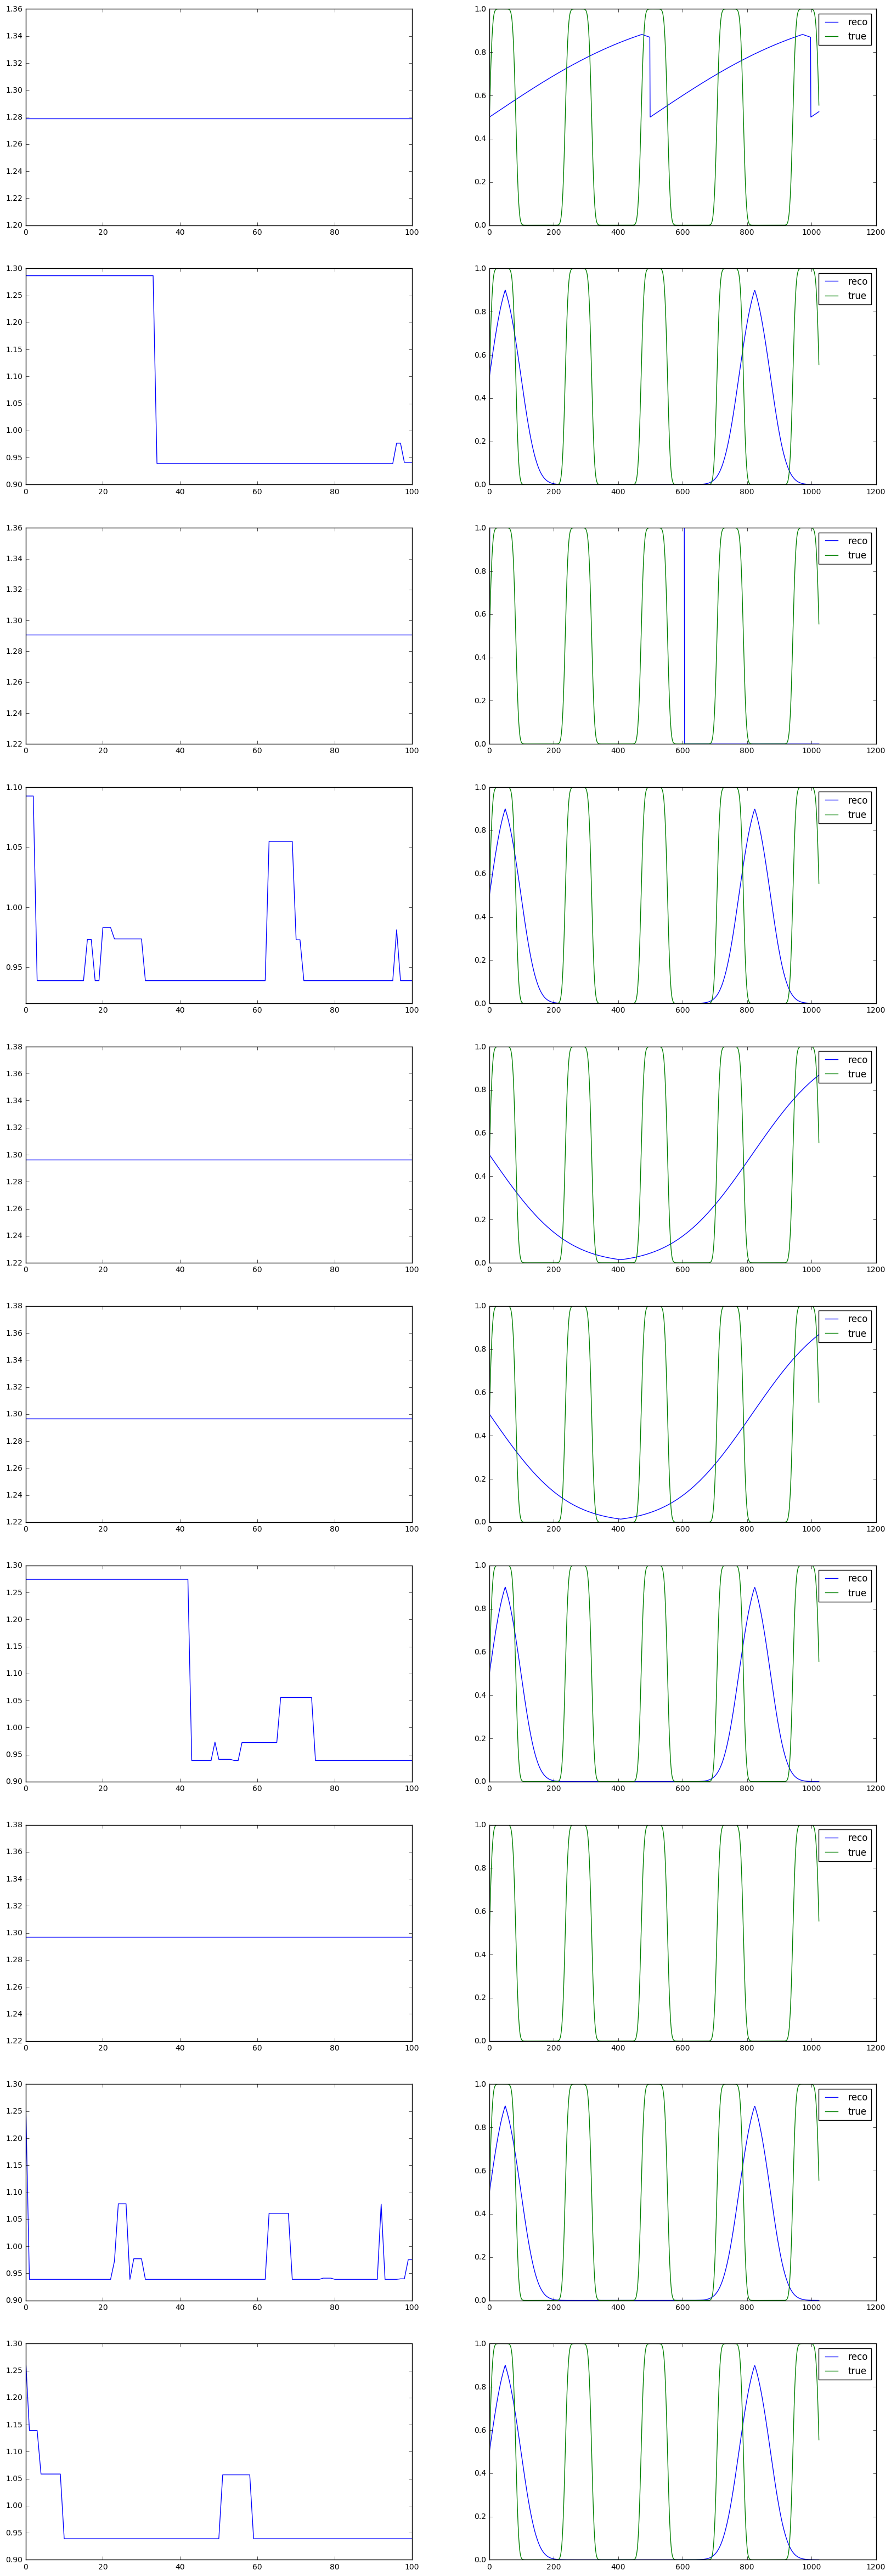

In [7]:
fig = plt.figure(figsize=(20, len(results)*6))

i = 0
for result in results:
    xs, fs, accs, ret = result.xs, result.fs, result.accs, result.bh_return
    true_dist         = result.synthetic.true_dist
    start_params      = result.start_params
    true_params       = result.synthetic.true_params
    
    # Show return
    print(ret)
    
    p_opt = model_driven_reco.get_params(ret)
    dist_opt = dist_model(p_opt['sigma'], p_opt['pitch'], p_opt['fsize'], x)
    acc_minima = model_driven_reco.accepted_minima_only(fs, accs)
    
    print('Start parameters:         ', start_params)
    print('True parameters:          ', true_params)
    print('Optimal found parameters: ', p_opt)
    print('')
    
    # Show sequence of accepted minima over all iterations
    fig.add_subplot(len(results), 2, 2*i+1)
    plt.plot(np.log(acc_minima)/np.log(10))
    
    # Show true and reconstructed distributions
    fig.add_subplot(len(results), 2, 2*i+2)
    plt.plot(dist_opt,  label='reco')
    plt.plot(true_dist, label='true')
    plt.legend()
    
    i += 1

## Save raw data

In [8]:
if False:
#if True:
    runId = 0
    for result in results:
        fn = 'synthetic_1D_grating__result__runId_{:02}__measId_{:02}__startId_{:02}.pickle'.format(runId, result.synthetic.measId, result.startId)
        print(fn)
        i+=1
        
        if os.path.exists(fn):
            raise FileExistsError('Error: path exists!')
        
        with open(fn, 'wb') as handle:
            pickle.dump(result, handle, protocol=pickle.HIGHEST_PROTOCOL)